# NBEATS MODEL

/Users/ayesharahman1/opt/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/120, Train Loss: 23.11988, Valid Loss: 0.04619
Epoch 2/120, Train Loss: 0.05896, Valid Loss: 0.09731
Epoch 3/120, Train Loss: 0.01571, Valid Loss: 0.01386
Epoch 4/120, Train Loss: 0.00172, Valid Loss: 0.00081
Epoch 5/120, Train Loss: 0.00320, Valid Loss: 0.04432
Epoch 6/120, Train Loss: 0.00805, Valid Loss: 0.01346
Epoch 7/120, Train Loss: 0.00496, Valid Loss: 0.02236
Epoch 8/120, Train Loss: 0.00437, Valid Loss: 0.01085
Epoch 9/120, Train Loss: 0.00509, Valid Loss: 0.08485
Epoch 10/120, Train Loss: 0.00661, Valid Loss: 0.01277
Epoch 11/120, Train Loss: 0.00344, Valid Loss: 0.00394
Epoch 12/120, Train Loss: 0.00079, Valid Loss: 0.00050
Epoch 13/120, Train Loss: 0.00069, Valid Loss: 0.00137
Epoch 14/120, Train Loss: 0.00041, Valid Loss: 0.00424
Epoch 15/120, Train Loss: 0.00039, Valid Loss: 0.00129
Epoch 16/120, Train Loss: 0.00044, Valid Loss: 0.00283
Epoch 17/120, Train Loss: 0.00037, Valid Loss: 0.00155
Epoch 18/120, Train Loss: 0.00034, Valid Loss: 0.00426
Epoch 19/120, Trai

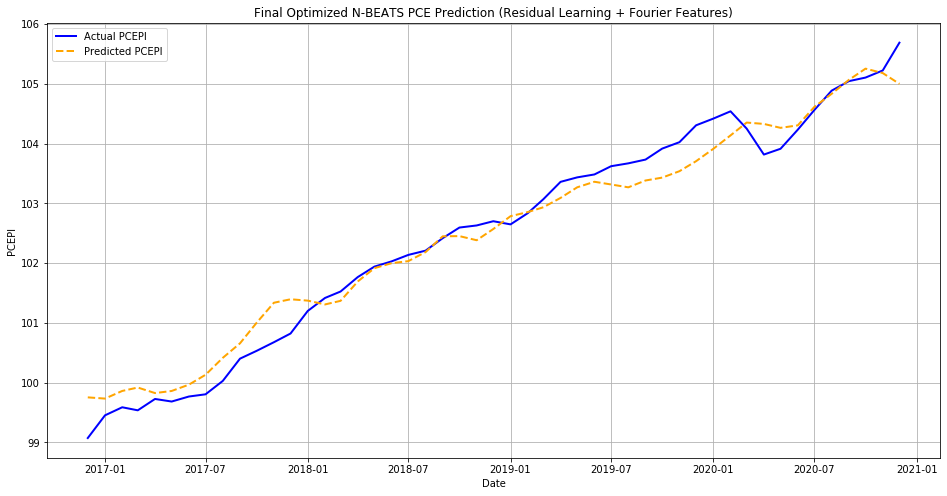

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.fftpack import fft
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and Format Data for N-BEATS
def load_data(train_file, sequence_length=48):
    df = pd.read_csv(train_file)
    df["observation_date"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
    df = df.sort_values(by="observation_date").reset_index(drop=True)

    target_col = "fred_PCEPI"
    data = df[[target_col]].values.astype(np.float32)

    # Compute Fourier Transform Features for Seasonality
    fft_features = np.abs(fft(data.flatten()))[:sequence_length]
    fft_features = (fft_features - np.min(fft_features)) / (np.max(fft_features) - np.min(fft_features))

    # Create Sequences (Past sequence_length Months → Next Month)
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(np.hstack([data[i : i + sequence_length].flatten(), fft_features]))  
        y.append(data[i + sequence_length])  

    X, y = np.array(X), np.array(y)

    # Train-Validation-Test Split (70%-15%-15%)
    train_idx = int(len(X) * 0.7)
    valid_idx = int(len(X) * 0.85)

    X_train, y_train = X[:train_idx], y[:train_idx]
    X_valid, y_valid = X[train_idx:valid_idx], y[train_idx:valid_idx]
    X_test, y_test = X[valid_idx:], y[valid_idx:]

    # Fix Data Leakage: Scale After Splitting
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)

    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
    y_valid = y_scaler.transform(y_valid.reshape(-1, 1))
    y_test = y_scaler.transform(y_test.reshape(-1, 1))

    return X_train, y_train, X_valid, y_valid, X_test, y_test, df["observation_date"][sequence_length:], scaler, y_scaler

# Convert Data to PyTorch Tensors
def prepare_dataloader(X, y, batch_size=32):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# N-BEATS Model with Residual Learning
class ResidualBlock(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ResidualBlock, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_size, output_size)
        )
        self.residual = nn.Linear(input_size, output_size)  # Residual connection

    def forward(self, x):
        x = x.view(x.shape[0], -1)  
        return self.hidden(x) + self.residual(x)  # Residual Learning

class NBeats(nn.Module):
    def __init__(self, input_size, hidden_size=512, output_size=1):
        super(NBeats, self).__init__()
        self.trend_block = ResidualBlock(input_size, hidden_size, output_size)
        self.seasonality_block = ResidualBlock(input_size, hidden_size, output_size)
        self.skip = nn.Linear(input_size, output_size)  # Skip connection

    def forward(self, x):
        trend = self.trend_block(x)
        seasonality = self.seasonality_block(x)
        skip_connection = self.skip(x.view(x.shape[0], -1))  # Shortcut
        return trend + seasonality + skip_connection

# Load Data and Create Model
train_file = "../Data/Train/trains1990s.csv"
X_train, y_train, X_valid, y_valid, X_test, y_test, dates, scaler, y_scaler = load_data(train_file)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBeats(input_size=X_train.shape[1]).to(device)

# Prepare DataLoaders
dataloader_train = prepare_dataloader(X_train, y_train)
dataloader_valid = prepare_dataloader(X_valid, y_valid)
dataloader_test = prepare_dataloader(X_test, y_test)

# Training Setup
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-7)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Train the Optimized N-BEATS Model with Early Stopping
def train_model(model, train_loader, valid_loader, loss_fn, optimizer, scheduler, device, max_epochs=120):
    model.train()
    best_valid_loss = float("inf")
    patience, patience_counter = 15, 0

    for epoch in range(max_epochs):
        train_loss, valid_loss = 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                valid_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss = valid_loss / len(valid_loader)
        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.5f}, Valid Loss: {avg_valid_loss:.5f}")

        # Pass validation loss to scheduler
        scheduler.step(avg_valid_loss)

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), "best_nbeats.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

train_model(model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device, max_epochs=120)

# Load Best Model and Evaluate on Test Set
model.load_state_dict(torch.load("best_nbeats.pth"))
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
predictions = model(X_test_tensor).detach().cpu().numpy()

# Convert Predictions Back to Original Scale
predictions = y_scaler.inverse_transform(predictions)
y_test_original = y_scaler.inverse_transform(y_test)

# Final Improved Graph
plt.figure(figsize=(16, 8))
plt.plot(dates[-len(y_test_original):], y_test_original, label="Actual PCEPI", color="blue", linewidth=2)
plt.plot(dates[-len(predictions):], predictions, label="Predicted PCEPI", linestyle="dashed", color="orange", linewidth=2)
plt.xlabel("Date")
plt.ylabel("PCEPI")
plt.title("Final Optimized N-BEATS PCE Prediction (Residual Learning + Fourier Features)")
plt.legend()
plt.grid()
plt.show()


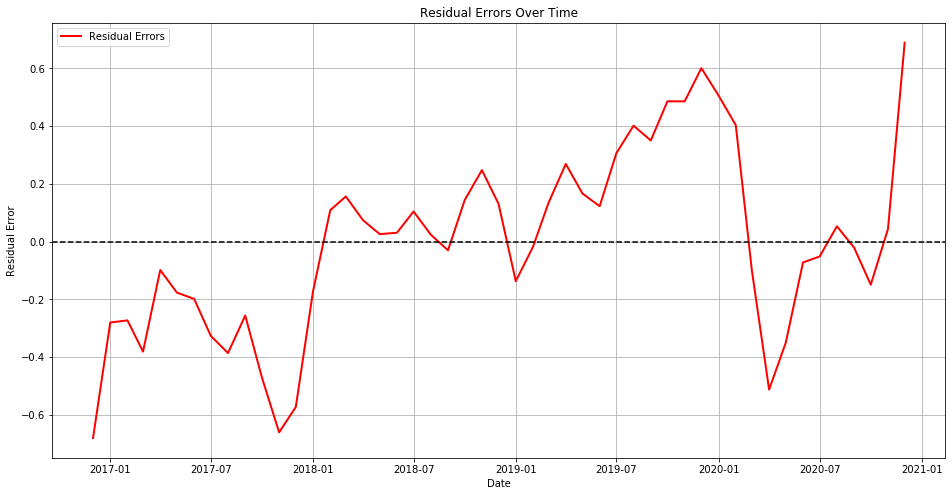

Mean Absolute Error (MAE): 0.25396
Root Mean Square Error (RMSE): 0.32019


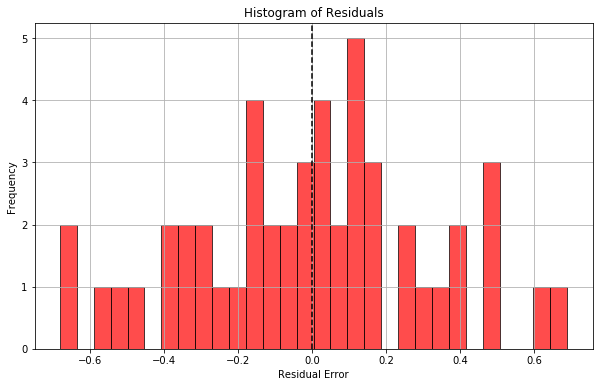

In [4]:
# Compute residual errors
residuals = y_test_original - predictions
plt.figure(figsize=(16, 8))
plt.plot(dates[-len(residuals):], residuals, label="Residual Errors", color="red", linewidth=2)
plt.axhline(y=0, color='black', linestyle='dashed')  # Reference line at 0
plt.xlabel("Date")
plt.ylabel("Residual Error")
plt.title("Residual Errors Over Time")
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute MAE
mae = mean_absolute_error(y_test_original, predictions)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))

print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"Root Mean Square Error (RMSE): {rmse:.5f}")

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', color='red', alpha=0.7)
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.axvline(x=0, color='black', linestyle='dashed')  # Reference line at 0
plt.grid()
plt.show()


